In [2]:
# Importing Libraries and Packages
import numpy as np
import pandas as pd
import yfinance as yf
from hmmlearn import hmm
from matplotlib import pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

### Data Preparation and Feature Engineering for Market State Classification



In [ ]:
# Step 1: Download historical market data
# Fetch historical data for the EFA ETF using Yahoo Finance API
etf = yf.download('EFA', start='2000-01-01', end='2020-09-24')
etf = etf[['Adj Close', 'Volume']]  # Retain only the adjusted close price and volume

# Step 2: Define cutoff dates for data splitting
# Split data into training, validation, and test sets based on predefined date ranges
cutoff = ['2000-01-01', '2010-01-01', '2015-01-01', '2020-01-01']
etf['date'] = etf.index  # Create a separate date column

# Create train, validation, and test datasets
train = etf[(etf['date'] >= cutoff[0]) & (etf['date'] < cutoff[1])]
validate = etf[(etf['date'] >= cutoff[1]) & (etf['date'] < cutoff[2])]
test = etf[(etf['date'] >= cutoff[2]) & (etf['date'] < cutoff[3])]

# Step 3: Calculate volatility
# Compute a 30-day rolling volatility (standard deviation normalized by mean)
# Drop rows with NaN values resulting from rolling calculations
for subset in [train, validate, test]:
    subset.loc[:, 'Volatility'] = subset['Adj Close'].rolling(window=30).std() / subset['Adj Close'].rolling(window=30).mean()
    subset.dropna(inplace=True)

# Step 4: Define a function to create rolling window features
# This function extracts normalized rolling windows of prices and volatility
def create_features(data):
    """
    Generate features from rolling windows of adjusted close prices and volatility.

    Parameters:
        data (DataFrame): Input dataset with 'Adj Close' and 'Volatility' columns.

    Returns:
        np.array: Flattened array of rolling window features.
    """
    out = []
    for i in range(30, len(data)):  # Rolling window of 30 days
        window = data['Adj Close'].iloc[i - 30:i]  # Adjusted close prices
        volatility = data['Volatility'].iloc[i - 30:i]  # Volatility
        
        # Normalize prices using the first value of the window
        normalized_window = window / window.iloc[0]
        
        # Combine normalized prices and volatility into a single feature set
        combined_features = np.hstack([
            normalized_window.values.reshape(-1, 1),  # Reshape for stacking
            volatility.values.reshape(-1, 1)
        ])
        out.append(combined_features.flatten())  # Flatten into 1D array
    
    return np.array(out)

# Generate features for training, validation, and testing
X_train = create_features(train)
X_val = create_features(validate)
X_test = create_features(test)

# Step 5: Create market state labels
# Label each time step as 0 (bear market) or 1 (bull market) based on price changes
Y_train = np.where(train['Adj Close'].pct_change().fillna(0) > 0, 1, 0)[30:]
Y_val = np.where(validate['Adj Close'].pct_change().fillna(0) > 0, 1, 0)[30:]
Y_test = np.where(test['Adj Close'].pct_change().fillna(0) > 0, 1, 0)[30:]

# Flatten labels to 1D arrays
Y_train = Y_train.ravel()
Y_val = Y_val.ravel()
Y_test = Y_test.ravel()

# Step 6: Standardize the feature data
# Normalize the features for better SVM performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Step 7: Train the SVM model
# Train a Support Vector Machine (SVM) classifier with an RBF kernel
svm = SVC(kernel='rbf', gamma=1.0, C=1.0)
svm.fit(X_train, Y_train)

# Step 8: Validate and test the model
# Predict market states for validation and test datasets
val_predictions = svm.predict(X_val)
test_predictions = svm.predict(X_test)



[*********************100%***********************]  1 of 1 completed
C:\Users\Artur\AppData\Local\Temp\ipykernel_9996\2284989266.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[:, 'Volatility'] = subset['Adj Close'].rolling(window=30).std() / subset['Adj Close'].rolling(window=30).mean()
C:\Users\Artur\AppData\Local\Temp\ipykernel_9996\2284989266.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.dropna(inplace=True)
C:\Users\Artur\AppData\Local\Temp\ipykernel_9996\2284989266.py:16: SettingWithCopyWarning: 
A value is trying to be set on 

### Visualizing SVM Predicted Market States

C:\Users\Artur\AppData\Local\Temp\ipykernel_9996\696664392.py:19: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(etf_test.index[hmm_state_0_cluster], etf_test['Adj Close'][hmm_state_0_cluster],
C:\Users\Artur\AppData\Local\Temp\ipykernel_9996\696664392.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(etf_test.index[hmm_state_0_cluster], etf_test['Adj Close'][hmm_state_0_cluster],
C:\Users\Artur\AppData\Local\Temp\ipykernel_9996\696664392.py:23: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(etf_test.index[hmm_state_1_cluster], etf_test['Adj Close'][hmm_state_1_cluster],
C:\Users\Artur\AppData\Local\Temp\ipykernel_9996\696664392.py:23: UserWarning: marker 

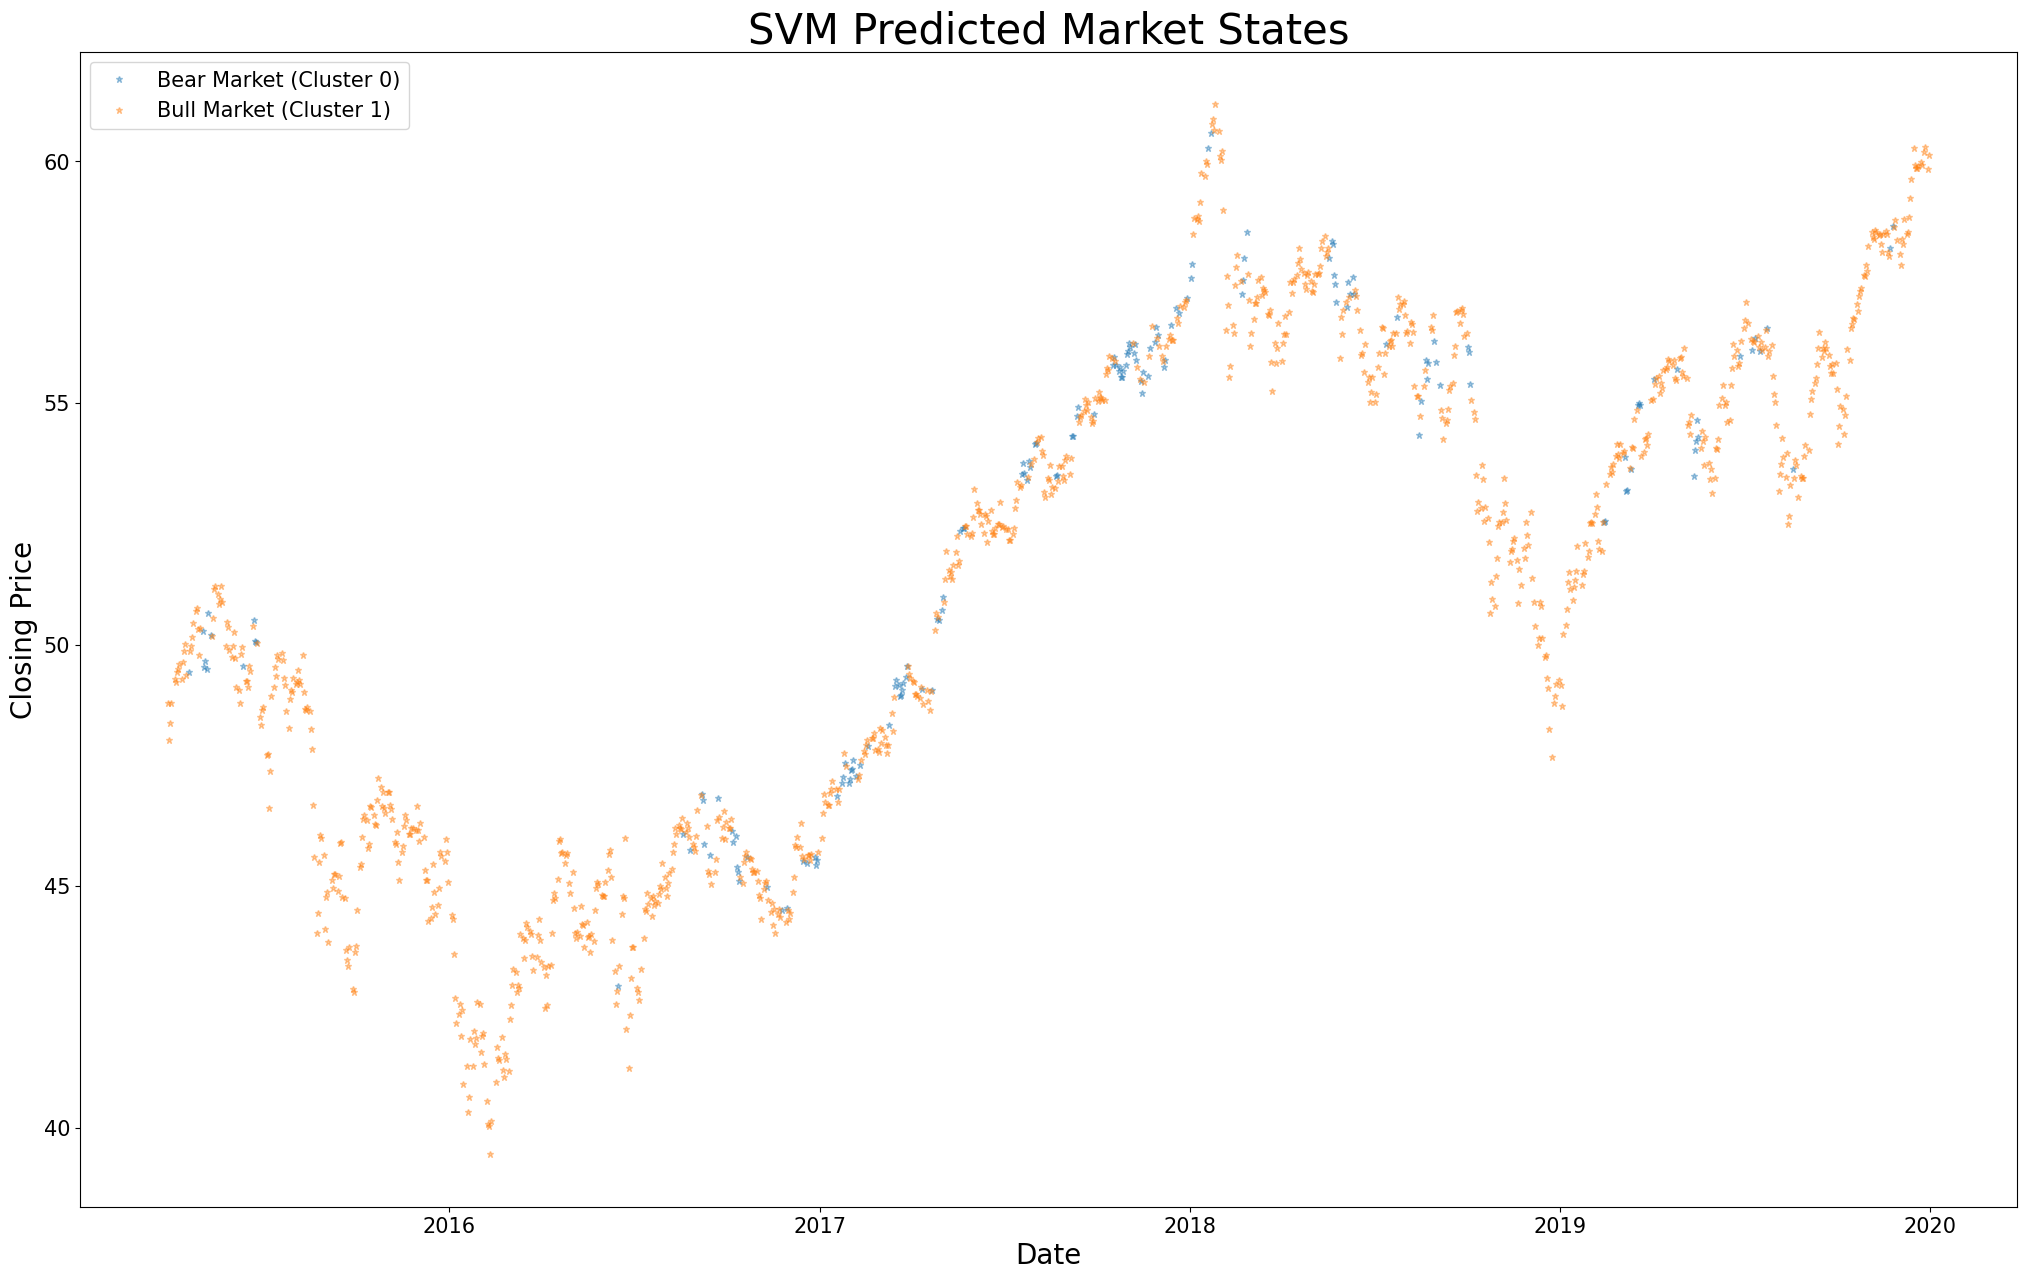

In [8]:
# Step 1: Prepare data for visualization
# Create a pandas Series to store predicted states, indexed by the test dataset dates
pred_states = pd.Series(test_predictions, index=test.index[-len(test_predictions):])

# Extract the corresponding test dataset subset for visualization
etf_test = etf.loc[test.index[-len(test_predictions):]]

# Step 2: Define clusters based on predicted market states
# Cluster 0: Bear Market, Cluster 1: Bull Market
hmm_state_0_cluster = pred_states == 0  # Indices where SVM predicts bear market
hmm_state_1_cluster = pred_states == 1  # Indices where SVM predicts bull market

# Step 3: Initialize the plot
fig = plt.figure(figsize=(25, 15))
hidden_svm_states = fig.add_subplot(111)

# Step 4: Plot clusters with distinctive markers
# Plot bear market states (Cluster 0) with red asterisks
plt.plot_date(etf_test.index[hmm_state_0_cluster], etf_test['Adj Close'][hmm_state_0_cluster],
              marker='*', ms=5, alpha=0.4, label='Bear Market (Cluster 0)')

# Plot bull market states (Cluster 1) with green asterisks
plt.plot_date(etf_test.index[hmm_state_1_cluster], etf_test['Adj Close'][hmm_state_1_cluster],
              marker='*', ms=5, alpha=0.4, label='Bull Market (Cluster 1)')

# Step 5: Customize the plot aesthetics
# Add title, axis labels, and adjust tick parameters for readability
hidden_svm_states.set_title('SVM Predicted Market States', fontsize=30)
hidden_svm_states.set_xlabel("Date", fontsize=20)
hidden_svm_states.set_ylabel("Closing Price", fontsize=20)
hidden_svm_states.tick_params(axis='both', labelsize=15)

# Add a legend to indicate market state clusters
hidden_svm_states.legend(loc='upper left', fontsize=15)

# Step 6: Display the plot
plt.show()


### Data Preparation and Hidden Markov Model (HMM) Training

In [9]:
# Step 1: Download historical market data
# Fetch historical data for the EFA ETF using Yahoo Finance API
etf = yf.download('EFA', start='2000-01-01', end='2020-09-24')
etf = etf[['Adj Close', 'Volume']]  # Retain only adjusted close price and volume

# Step 2: Define cutoff dates for splitting data
# Split the data into training, validation, and test sets using specific date ranges
cutoff = ['2000-01-01', '2010-01-01', '2015-01-01', '2020-01-01']
etf['date'] = etf.index  # Add a date column for filtering

# Create train, validation, and test datasets based on cutoff dates
train = etf[(etf['date'] >= cutoff[0]) & (etf['date'] < cutoff[1])]
validate = etf[(etf['date'] >= cutoff[1]) & (etf['date'] < cutoff[2])]
test = etf[(etf['date'] >= cutoff[2]) & (etf['date'] < cutoff[3])]

# Step 3: Calculate volatility for each dataset
# Compute 30-day rolling volatility (standard deviation normalized by mean)
# Drop rows with NaN values resulting from rolling calculations
for subset in [train, validate, test]:
    subset.loc[:, 'Volatility'] = subset['Adj Close'].rolling(window=30).std() / subset['Adj Close'].rolling(window=30).mean()
    subset.dropna(inplace=True)

# Step 4: Define a function to create rolling window features
def create_features(data):
    """
    Generate rolling window features using adjusted close prices and volatility.

    Parameters:
        data (DataFrame): Dataset containing 'Adj Close' and 'Volatility' columns.

    Returns:
        np.array: Flattened array of rolling window features.
    """
    out = []
    for i in range(30, len(data)):  # Rolling window of 30 days
        window = data['Adj Close'].iloc[i - 30:i]  # Adjusted close prices
        volatility = data['Volatility'].iloc[i - 30:i]  # Volatility
        
        # Normalize the price window using the first value
        normalized_window = window / window.iloc[0]
        
        # Stack normalized prices and volatility into a single feature set
        combined_features = np.hstack([
            normalized_window.values.reshape(-1, 1),  # Reshape for stacking
            volatility.values.reshape(-1, 1)
        ])
        out.append(combined_features.flatten())  # Flatten into 1D array
    return np.array(out)

# Step 5: Generate features for training, validation, and testing
X_train = create_features(train)  # Features for training
X_val = create_features(validate)  # Features for validation
X_test = create_features(test)  # Features for testing

# Step 6: Train a Hidden Markov Model (HMM)
# Fit an HMM with 2 hidden states (e.g., bull and bear market states)
hmm_1 = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)
hmm_1.fit(X_train)

# Step 7: Predict hidden states
# Use the trained HMM to predict hidden states for each dataset
train_hidden_states = hmm_1.predict(X_train)  # Hidden states for training set
val_hidden_states = hmm_1.predict(X_val)  # Hidden states for validation set
test_hidden_states = hmm_1.predict(X_test)  # Hidden states for testing set


[*********************100%***********************]  1 of 1 completed
C:\Users\Artur\AppData\Local\Temp\ipykernel_9996\1115517363.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[:, 'Volatility'] = subset['Adj Close'].rolling(window=30).std() / subset['Adj Close'].rolling(window=30).mean()
C:\Users\Artur\AppData\Local\Temp\ipykernel_9996\1115517363.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.dropna(inplace=True)
C:\Users\Artur\AppData\Local\Temp\ipykernel_9996\1115517363.py:20: SettingWithCopyWarning: 
A value is trying to be set on 

### Visualizing Hidden Markov Model (HMM) Predicted Market States

C:\Users\Artur\AppData\Local\Temp\ipykernel_9996\1447201605.py:20: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(etf_test.index[hmm_state_0_cluster], etf_test['Adj Close'][hmm_state_0_cluster],
C:\Users\Artur\AppData\Local\Temp\ipykernel_9996\1447201605.py:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(etf_test.index[hmm_state_0_cluster], etf_test['Adj Close'][hmm_state_0_cluster],
C:\Users\Artur\AppData\Local\Temp\ipykernel_9996\1447201605.py:24: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(etf_test.index[hmm_state_1_cluster], etf_test['Adj Close'][hmm_state_1_cluster],
C:\Users\Artur\AppData\Local\Temp\ipykernel_9996\1447201605.py:24: UserWarning: mar

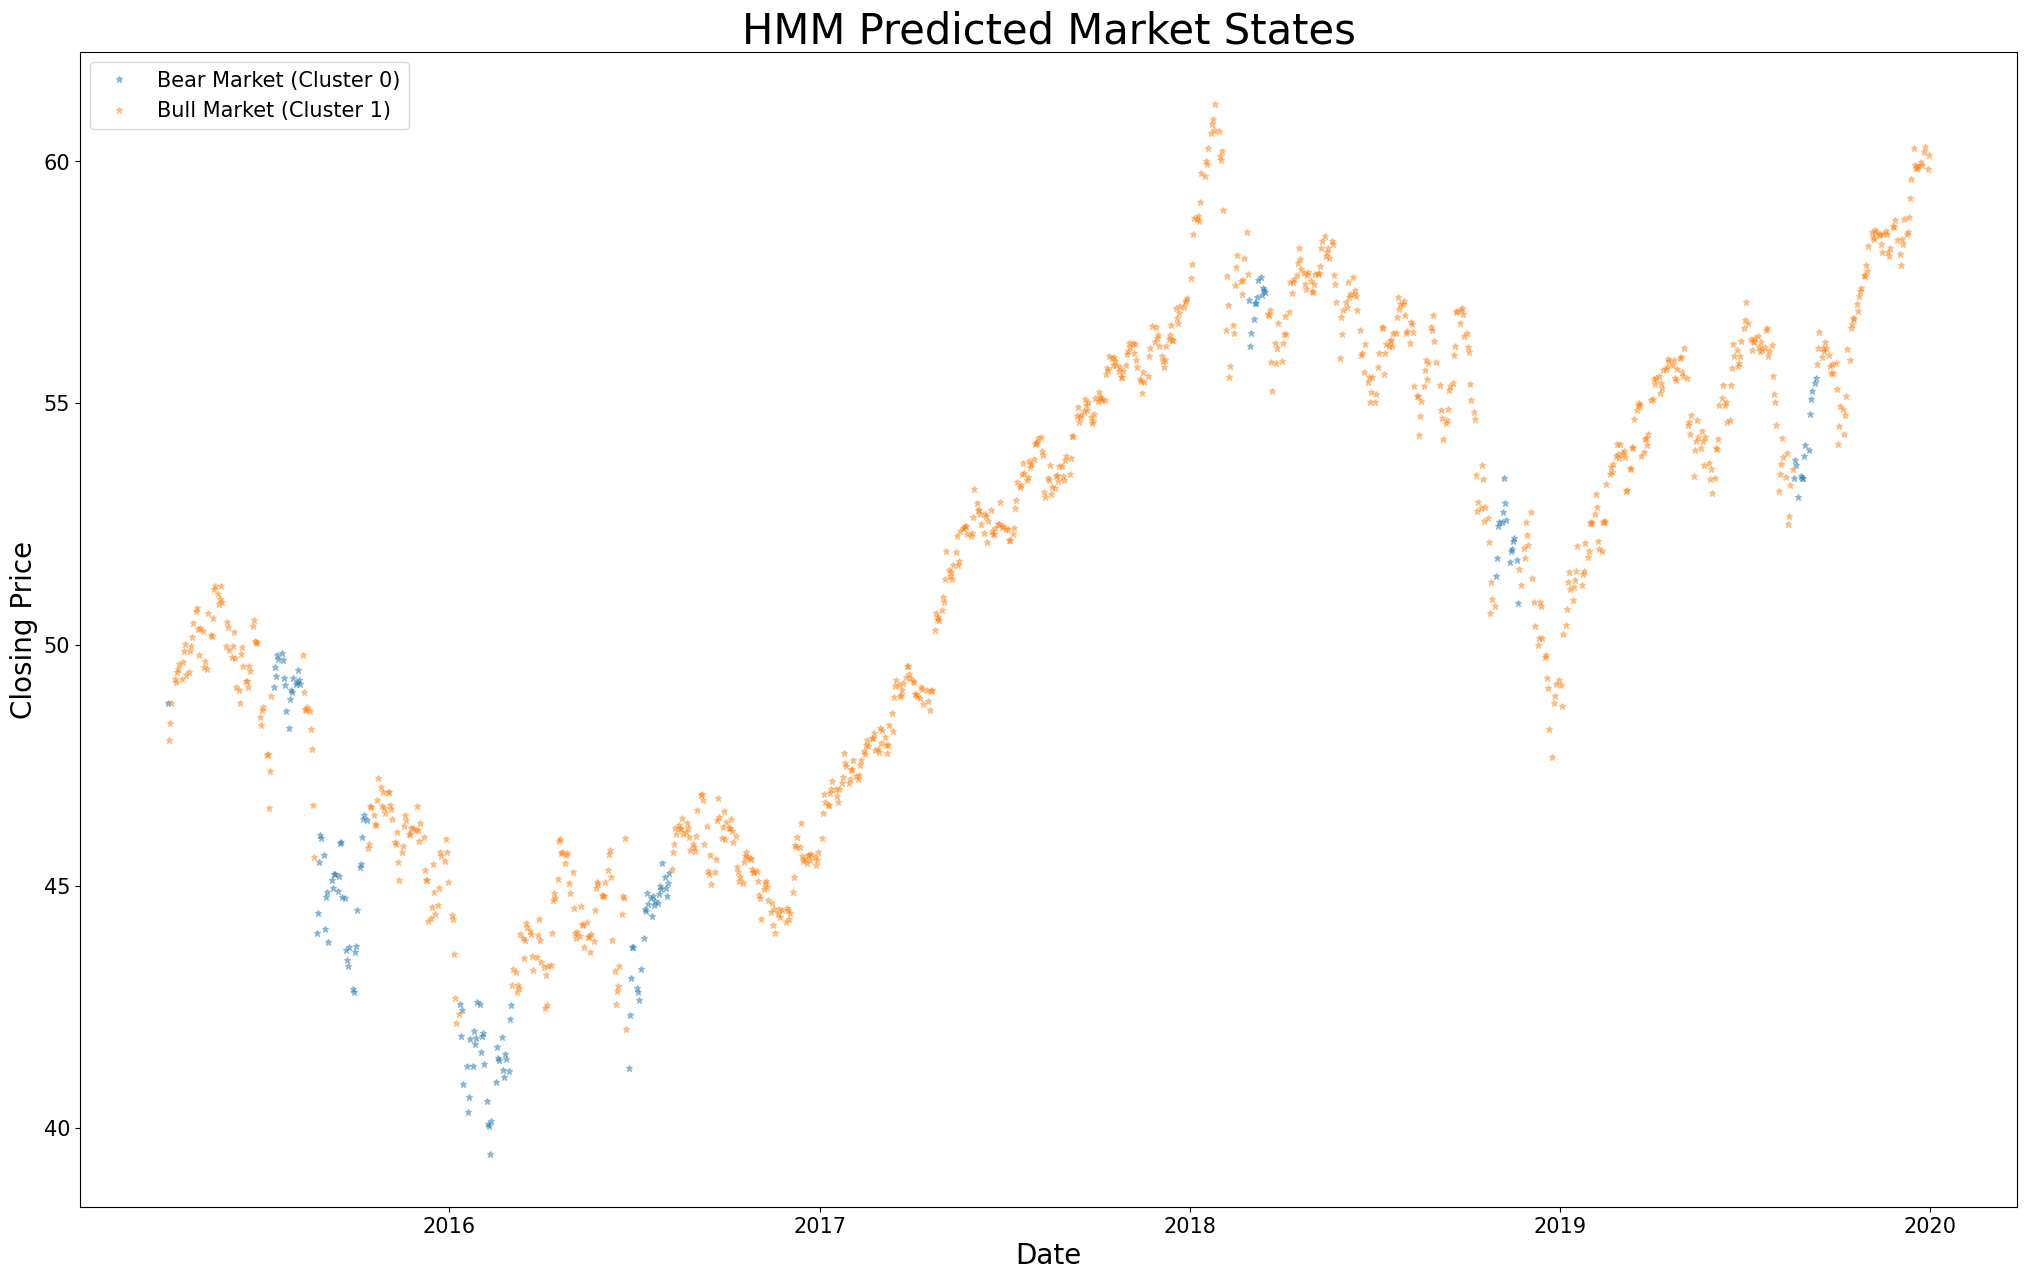

In [10]:
# Step 1: Prepare data for visualization
# Create a pandas Series to store HMM-predicted hidden states, indexed by the test dataset dates
pred_states = pd.Series(test_hidden_states, index=test.index[-len(test_hidden_states):])

# Extract the corresponding subset of the test dataset for plotting
etf_test = etf.loc[test.index[-len(test_hidden_states):]]

# Step 2: Define clusters based on predicted hidden states
# Cluster 0: Bear Market, Cluster 1: Bull Market
hmm_state_0_cluster = pred_states == 0  # Indices where HMM predicts bear market
hmm_state_1_cluster = pred_states == 1  # Indices where HMM predicts bull market

# Step 3: Initialize the plot
# Set up a figure to plot the predicted hidden states
fig = plt.figure(figsize=(25, 15))
hidden_svm_states = fig.add_subplot(111)

# Step 4: Plot each market state cluster
# Plot bear market states (Cluster 0) with red asterisks
plt.plot_date(etf_test.index[hmm_state_0_cluster], etf_test['Adj Close'][hmm_state_0_cluster],
              marker='*', ms=5, alpha=0.4, label='Bear Market (Cluster 0)')

# Plot bull market states (Cluster 1) with green asterisks
plt.plot_date(etf_test.index[hmm_state_1_cluster], etf_test['Adj Close'][hmm_state_1_cluster],
              marker='*', ms=5, alpha=0.4, label='Bull Market (Cluster 1)')

# Step 5: Customize the plot aesthetics
# Add a title, axis labels, and adjust tick parameters for better readability
hidden_svm_states.set_title('HMM Predicted Market States', fontsize=30)
hidden_svm_states.set_xlabel("Date", fontsize=20)
hidden_svm_states.set_ylabel("Closing Price", fontsize=20)
hidden_svm_states.tick_params(axis='both', labelsize=15)

# Add a legend to distinguish market state clusters
hidden_svm_states.legend(loc='upper left', fontsize=15)

# Step 6: Display the plot
# Show the visual representation of predicted market states
plt.show()
